In [ ]:
!pip install git+https://github.com/huggingface/transformers -q
!pip list | grep -E 'transformers/tokenizers' -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 182 kB 8.1 MB/s 
     |████████████████████████████████| 7.6 MB 38.4 MB/s 


In [ ]:
!pip install tensorflow -q

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
# from transformers import BertTokenizer, BertConfig, BertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from transformers import AdamW, get_linear_schedule_with_warmup 
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'A100-SXM4-40GB'

In [ ]:
%cd drive/MyDrive/data

/content/drive/MyDrive/data


In [ ]:
train = pd.read_csv("train.csv")
train.shape

(9989, 5)

In [ ]:
train.sample(10)

,ID,Utterance,Speaker,Dialogue_ID,Target
280,TRAIN_0280,"Okay, all right, all right, all right! Okay! ...",Chandler,27,joy
6339,TRAIN_6339,That was amazing!,Chandler,663,joy
5256,TRAIN_5256,Really?! I-I thought you weren’t looking for s...,Chandler,558,surprise
1379,TRAIN_1379,"Well, let me ask you something, was Kip a bett...",Joey,148,sadness
956,TRAIN_0956,No?,Ross,100,surprise
3812,TRAIN_3812,"Ross, you're like my best friend.",Rachel,410,joy
3746,TRAIN_3746,"No, Chandler.",Joey,404,neutral
8119,TRAIN_8119,If you are not going to learn how to ride this...,Ross,853,anger
8459,TRAIN_8459,Oh hey you guys!,Phoebe,891,joy
2823,TRAIN_2823,Umm?,Chandler,299,neutral


In [ ]:
sentences = train.Utterance.values
# sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]

In [ ]:
train['labels'] = train['Target'].map({'neutral':0,
                                 'joy':1,
                                 'surprise':2,
                                 'anger':3,
                                 'sadness':4,
                                 'disgust':5,
                                 'fear':6})

labels = train.labels.values

In [ ]:
from transformers import AutoTokenizer

model_name = 'tae898/emoberta-large'
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print (tokenized_texts[0])

Downloading:   0%|          | 0.00/408 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

['also', 'ĠI', 'Ġwas', 'Ġthe', 'Ġpoint', 'Ġperson', 'Ġon', 'Ġmy', 'Ġcompany', 'âĢ', 'Ļ', 's', 'Ġtransition', 'Ġfrom', 'Ġthe', 'ĠKL', '-', '5', 'Ġto', 'ĠGR', '-', '6', 'Ġsystem', '.']


In [ ]:
Max_len = 128

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen = Max_len, dtype = "long", truncating = "post", padding = "post")

In [ ]:
attention_masks = []

for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [ ]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.2)

In [ ]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler = validation_sampler, batch_size = batch_size)

In [ ]:
from transformers import AutoModel

configuration = AutoConfig.from_pretrained(model_name)
model = AutoModel.from_config(configuration)
configuration = model.config
print(configuration)

Downloading:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

RobertaConfig {
  "_name_or_path": "tae898/emoberta-large",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "neutral",
    "1": "joy",
    "2": "surprise",
    "3": "anger",
    "4": "sadness",
    "5": "disgust",
    "6": "fear"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "anger": 3,
    "disgust": 5,
    "fear": 6,
    "joy": 1,
    "neutral": 0,
    "sadness": 4,
    "surprise": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.25.0.dev0",
  "type_vocab_s

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 7)
model.cuda()

Downloading:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
         

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
    {'params' : [p for n,p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate' : 0.0}
]

In [ ]:
epochs = 4

optimizer = AdamW(optimizer_grouped_parameters,
                  lr = 2e-5,
                  eps = 1e-8 # args.adam_epsilon
                  )

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
t = []

train_loss_set = []

for _ in trange(epochs, desc = "Epoch"):
  model.train()
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0,0

  for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    optimizer.zero_grad()
    outputs = model(b_input_ids, token_type_ids = None, attention_mask = b_input_mask, labels = b_labels)

    loss = outputs['loss']
    train_loss_set.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()

    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("train loss : {}".format(tr_loss/nb_tr_steps))

  # val

  model.eval()

  eval_loss, eval_accuracy = 0,0
  nb_eval_steps, nb_eval_examples = 0,0

  for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
      logits = model(b_input_ids, token_type_ids = None, attention_mask = b_input_mask)
    
    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps +=1
  
  print("val accuracy : {}".format(eval_accuracy/nb_eval_steps))


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

train loss : 1.1022453608512879


Epoch:  25%|██▌       | 1/4 [02:18<06:55, 138.49s/it]

val accuracy : 0.6932397959183674
train loss : 0.9004570246934891


Epoch:  50%|█████     | 2/4 [04:34<04:33, 136.97s/it]

val accuracy : 0.6930980725623582
train loss : 0.7338135036230087


Epoch:  75%|███████▌  | 3/4 [06:50<02:16, 136.48s/it]

val accuracy : 0.7074829931972789
train loss : 0.6016523016691208


Epoch: 100%|██████████| 4/4 [09:06<00:00, 136.54s/it]

val accuracy : 0.7071286848072563


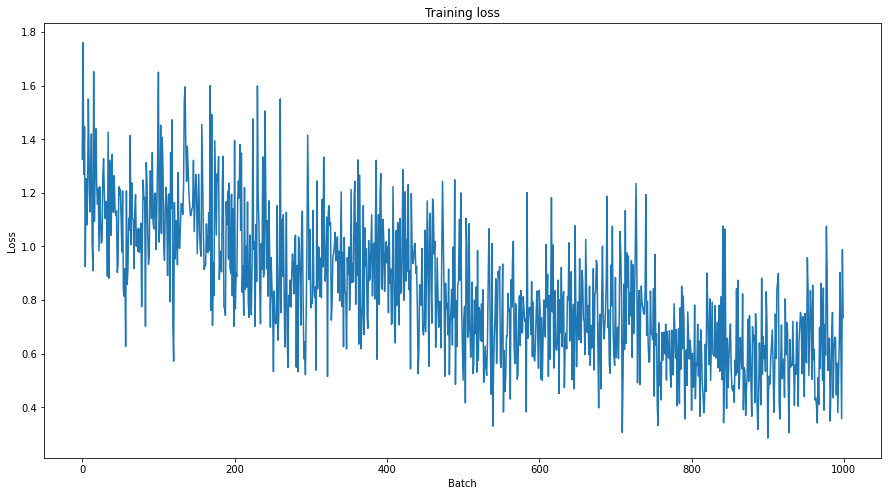

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

### test

In [ ]:
test = pd.read_csv("test.csv")

sentences = test.Utterance.values
test_tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

Max_len = 128

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in test_tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen = Max_len, dtype = "long", truncating = "post", padding = "post")

attention_masks = []

for seq in input_ids :
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)

batch_size = 32

prediction_data = TensorDataset(prediction_inputs, prediction_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
model.eval()

predictions = []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask = batch

  with torch.no_grad():
    logits = model(b_input_ids, token_type_ids = None, attention_mask = b_input_mask)
    
  logits = logits['logits'].detach().cpu().numpy()
  predictions.append(logits)

In [ ]:
pred = np.concatenate(predictions).tolist()
y_pred = np.argmax(pred,1)

In [ ]:
sample = pd.read_csv("sample_submission.csv")
sample['Target'] = y_pred
sample.head()

,ID,Target
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,1


In [ ]:
sample['Target'].value_counts()

0    1307
1     452
2     310
3     301
4     146
5      52
6      42
Name: Target, dtype: int64

In [ ]:
sample.to_csv('emoberta_submit_8.csv', index = False)